# Creating figures

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as sco
import numpy_linalg as la

In [2]:
import sl_py_tools.matplotlib_tricks as mplt
import sl_py_tools.numpy_tricks.markov as ma
import sl_py_tools.numpy_tricks.markov_param as mp

In [3]:
import complex_synapse as cs

In [4]:
from sl_py_tools.import_tricks import reload

In [5]:
np.set_printoptions(precision=3, suppress=False, linewidth=90)
mplt.rc_fonts()
mplt.rc_colours()

## Examples

In [6]:
t = la.geomspace(0.1, 1e4, 50)
nst = 10
jmp=0.7

In [7]:
serial = cs.SynapseMemoryModel.build(cs.builders.build_serial, nst, jmp=jmp)
cascade = cs.SynapseMemoryModel.build(cs.builders.build_cascade, nst, jmp=jmp)

In [8]:
serial_snr = serial.snr_exp_ave(t)
cascade_snr = cascade.snr_exp_ave(t)

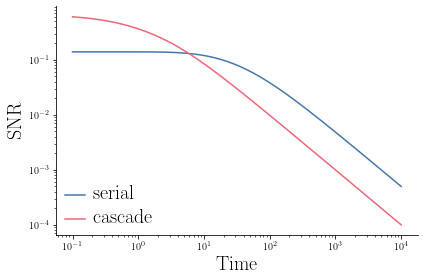

In [9]:
fig_sc, ax = plt.subplots()
ax.loglog(t, serial_snr, label='serial')
ax.loglog(t, cascade_snr, label='cascade')
ax.set_xlabel("Time")
ax.set_ylabel("SNR")
lg = ax.legend(loc="lower left")
mplt.clean_axes(ax)

### Test shifting

In [15]:
with serial.shifted(1/t, None):
    serial_shift_ones = serial.snr_area() / t
with serial.shifted(1/t, np.nan):
    serial_shift_peq = serial.snr_area() / t
np.fabs(serial_snr - serial_shift_ones).max()[()], np.fabs(serial_shift_peq - serial_shift_ones).max()[()]

(2.7755575615628914e-16, 1.3877787807814457e-16)

## Optimisation

In [6]:
nst = 10
s = la.geomspace(1e-4, 10, 50)
options = {'repeats': 10, 'method': 'SLSQP'}
envelope_theory = cs.optimise.proven_envelope_laplace(s, nst)

In [7]:
envelope_srl, models_srl = cs.optimise.optim_laplace_range(s, nst, serial=True, **options)
envelope_gen, models_gen = cs.optimise.optim_laplace_range(s, nst, serial=False, **options)

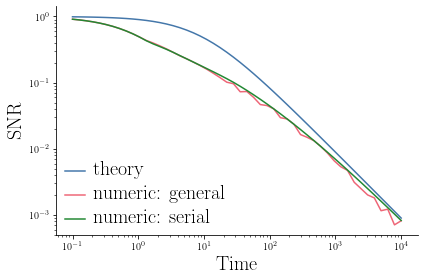

In [8]:
fig_num, ax = plt.subplots()
ax.loglog(1/s, envelope_theory * s, label='theory')
ax.loglog(1/s, envelope_gen * s, label='numeric: general')
ax.loglog(1/s, envelope_srl * s, label='numeric: serial')
ax.set_xlabel("Time")
ax.set_ylabel("SNR")
lg = ax.legend(loc="lower left")
mplt.clean_axes(ax)

### Shifted optimisation

In [8]:
senvelope_gen, smodels_gen = cs.optimise.optim_laplace_range(
    s, nst, maker=cs.optimise.make_shifted_problem, CondThresh=1e4, **options)
penvelope_gen, pmodels_gen = cs.optimise.optim_laplace_range(
    s, nst, maker=cs.optimise.make_shift_peq_problem, CondThresh=1e3, **options)


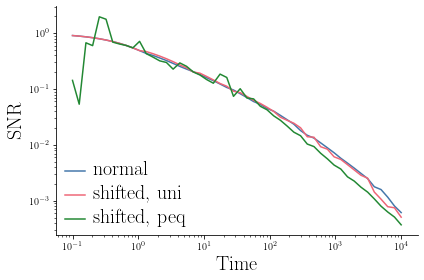

In [9]:
fig_shift, ax = plt.subplots()
ax.loglog(1/s, envelope_gen * s, label='normal')
ax.loglog(1/s, senvelope_gen * s, label='shifted, uni')
ax.loglog(1/s, penvelope_gen * s, label='shifted, peq')
ax.set_xlabel("Time")
ax.set_ylabel("SNR")
lg = ax.legend(loc="lower left")
mplt.clean_axes(ax)

## Saving/loading

In [11]:
np.savez_compressed("optim", s=s, envelope_theory=envelope_theory,
envelope_gen=envelope_gen, envelope_srl=envelope_srl, senvelope_gen=senvelope_gen, penvelope_gen=senvelope_gen, 
models_gen=models_gen, models_srl=models_srl, smodels_gen=smodels_gen, pmodels_gen=smodels_gen, 
nst=nst, options=options)

In [7]:
saved = np.load('optim.npz', allow_pickle=True)
s = saved['s']
envelope_theory = saved['envelope_theory']
envelope_gen = saved['envelope_gen']
envelope_srl = saved['envelope_srl']
senvelope_gen = saved['senvelope_gen']
penvelope_gen = saved['penvelope_gen']
models_gen = saved['models_gen']
models_srl = saved['models_srl']
smodels_gen = saved['smodels_gen']
pmodels_gen = saved['pmodels_gen']
options = saved['options'][()]
nst = saved['nst'][()]
saved.close()

In [12]:
conds = cs.optimise.check_cond_range(s, smodels_gen)
condp = cs.optimise.check_cond_range(s, pmodels_gen)


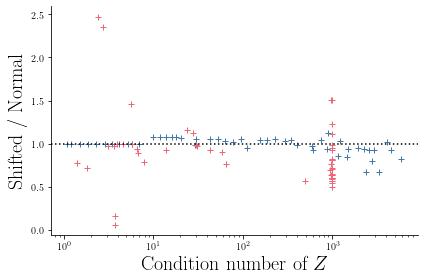

In [15]:
fig_cond, ax = plt.subplots()
# good = senvelope_gen < envelope_gen
# bad = np.logical_not(good)
# ax.semilogx(conds[good], senvelope_gen[good] / envelope_gen[good], '+',
#             conds[bad], senvelope_gen[bad] / envelope_gen[bad], '+')
ax.semilogx(conds, senvelope_gen / envelope_gen, '+')
ax.semilogx(condp, penvelope_gen / envelope_gen, '+')
xlim = ax.get_xlim()
ax.semilogx(xlim, (1, 1), 'k:')
ax.set_xlim(xlim)
ax.set_xlabel('Condition number of $Z$')
ax.set_ylabel('Shifted / Normal')
# mplt.centre_spines(ax, 1, 1, arrow=False, centre_tick='x')
mplt.clean_axes(ax)

In [21]:
reload(cs)
reload(mp)
reload(la)

Reloading complex_synapse.synapse_memory_model
Reloading sl_py_tools.numpy_tricks
Reloading complex_synapse.builders
Reloading complex_synapse.synapse_base
Reloading complex_synapse.synapse_opt
Reloading sl_py_tools.numpy_tricks.markov
Reloading numpy_linalg._lnarray
Reloading numpy_linalg.gufuncs
Reloading numpy_linalg.gufuncs._families
Reloading numpy_linalg.gufuncs._gufuncs_cloop
Reloading numpy_linalg.gufuncs._gufuncs_blas
Reloading numpy_linalg.gufuncs._gufuncs_lu_solve
Reloading numpy_linalg.gufuncs._gufuncs_qr_lstsq
Reloading numpy_linalg.gufuncs._util
Reloading numpy_linalg.version
Reloading packaging.version
Reloading packaging._structures
Reloading packaging._typing
Reloading numpy_linalg.convert
Reloading numpy_linalg.wrappers
Reloading numpy_linalg._linalg
Reloading numpy_linalg._ln_creation
Reloading numpy_linalg._ln_manipulation
